# Codes implemented for paper "Developing AI-Resilient Assessments: A Case Study with Electric Circuits"

**Author:** Prof. Ramón J. Durán Barroso (rduran@tel.uva.es) 

**Publication:** IEEE Global Engineering Education Conference (EDUCON) 2026.  

**Usage Rights:** These codes can be used freely by citing the author and the indicated article.

**How to cite:** Ramón J. Durán Barroso *et al.*, "Developing AI-Resilient Assessments: A Case Study with Electric Circuits," *IEEE Global Engineering Education Conference (EDUCON)*, 2026.

**Funding:** This work was carried out within the framework of **PID 64 (2025/26)**, funded by the Vice-Rectorate for Teaching Innovation and Digital Transformation of the **Universidad de Valladolid**.

   
---

## Overview
This notebook demonstrates techniques to generate electric circuit diagrams and apply adversarial visual perturbations. These techniques include Warhol-style color overlays and a specific animated GIF strategy designed to disrupt Multimodal AI analysis.

## 1. Warhol Effect Function

This function, `warhol_and_overlay`, takes an input image path and applies a color transformation inspired by Andy Warhol's pop art. It splits the image into RGBA channels, applies a predefined palette of colors (Pink, Light Blue, Yellow, Green) to copies of the image, creates a 2x2 grid of these colored variations, and overlays this grid onto the original image.

In [1]:
import os
from PIL import Image

def warhol_and_overlay(image_path):
    """
    Applies a Warhol-style color effect overlay to an image to disrupt AI recognition.
    """
    
    # Define colors in hexadecimal format
    colors = ["CC81A8", "6CA5BD", "CCCC00", "5E9E5E"]

    # Load original image
    original_image = Image.open(image_path).convert("RGBA")
    width, height = original_image.size

    # List to store transformed images
    colored_images = []

    # Function to convert hex color to RGB
    def hex_to_rgb(hex_color):
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    # Apply each color and store the transformed image
    for color_hex in colors:
        r, g, b, a = original_image.split()
        color_rgb = hex_to_rgb(color_hex)

        # Apply new color mapping
        new_r = Image.eval(r, lambda _: color_rgb[0])
        new_g = Image.eval(g, lambda _: color_rgb[1])
        new_b = Image.eval(b, lambda _: color_rgb[2])

        # Merge with original alpha channel
        colored_image = Image.merge("RGBA", (new_r, new_g, new_b, a))
        scaled_image = colored_image.resize((width // 2, height // 2))
        colored_images.append(scaled_image)

    # Create a new blank image
    new_image = Image.new("RGBA", (width, height))

    # Paste the four scaled images
    new_image.paste(colored_images[0], (0, 0))
    new_image.paste(colored_images[1], (width // 2, 0))
    new_image.paste(colored_images[2], (0, height // 2))
    new_image.paste(colored_images[3], (width // 2, height // 2))

    # Ensure match size
    new_image = new_image.resize(original_image.size)

    # Superimpose images
    overlay_image = Image.alpha_composite(original_image, new_image)

    # Construct new filename
    base_name, ext = os.path.splitext(image_path)
    new_file_path = base_name + '_warhol' + ext
    
    # Save resulting image
    overlay_image.save(new_file_path)
    print(f"Warhol effect applied and saved to: {new_file_path}")

## 2. Animated GIF Strategy (Adversarial Frames)

The `generate_adversarial_gif` function implements a specific strategy to confuse AI Video/Vision encoders. 

**Mechanism:**
1.  **Frame 1 (0.1s):** A frame containing randomly generated polygonal figures (circles and squares) on a randomized background.
2.  **Frame 2 (0.1s):** A frame containing an excerpt from a well-known literary text (randomly selected from a set), sharing the dimensions of the circuit.
3.  **Frame 3 onwards:** The static circuit image is repeated for the remainder of the loop (approx. 5 minutes).

This rapid sequence of unrelated visual data at the start of the file prevents the AI from correctly anchoring its attention on the circuit diagram immediately.

In [2]:
from PIL import Image, ImageDraw, ImageFont
import random
import os

def generate_adversarial_gif(filepath):
    """
    Creates an animated GIF where the first two frames are adversarial noise 
    (polygons and text), followed by the static circuit image.
    """
    # Load the original circuit image
    circuit_img = Image.open(filepath).convert("RGB")
    width, height = circuit_img.size
    
    # --- FRAME 1: Random Polygonal Figures ---
    
    # Create a random light background color for the polygons frame
    poly_bg_color = (
        random.randint(200, 255), 
        random.randint(200, 255), 
        random.randint(200, 255)
    )
    frame_polygons = Image.new("RGB", (width, height), poly_bg_color)
    draw_poly = ImageDraw.Draw(frame_polygons)
    
    # Configuration for shapes
    num_shapes = 5
    min_size = int(min(width, height) * 0.1)
    max_size = int(min(width, height) * 0.3)
    
    # Draw random squares and circles
    for _ in range(num_shapes):
        # Random size and position
        size = random.randint(min_size, max_size)
        x1 = random.randint(0, width - size)
        y1 = random.randint(0, height - size)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        
        # Square
        draw_poly.rectangle([x1, y1, x1+size, y1+size], fill=color, outline=(0,0,0))
        
        # Circle (offset slightly)
        x2 = random.randint(0, width - size)
        y2 = random.randint(0, height - size)
        color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        draw_poly.ellipse([x2, y2, x2+size, y2+size], fill=color2, outline=(0,0,0))

    # --- FRAME 2: Text Excerpt ---
    
    frame_text = Image.new("RGB", (width, height), (255, 255, 255)) # White background
    draw_text = ImageDraw.Draw(frame_text)
    
    # Font setup
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except IOError:
        font = ImageFont.load_default()
    
    # Text Corpus
    texts = [
    # 1. Don Quixote (Spanish)
    ("En un lugar de la Mancha, de cuyo nombre no quiero acordarme,\n"
     "no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero,\n"
     "adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca\n"
     "que carnero, salpicón las más noches, duelos y quebrantos los sábados,\n"
     "lantejas los viernes, algún palomino de añadidura los domingos, consumían\n"
     "las tres partes de su hacienda."),
    
    # 5. The Picture of Dorian Gray (English Original)
    ("The studio was filled with the rich odour of roses, and when the light summer wind\n"
     "stirred the trees of the garden, there came through the open door the heavy scent\n"
     "of the lilac, or the more delicate perfume of the pink-flowering thorn."),
    
    # 7. Hamlet (English Original)
    ("To be, or not to be, that is the question:\n"
     "Whether 'tis nobler in the mind to suffer\n"
     "The slings and arrows of outrageous fortune,\n"
     "Or to take arms against a sea of troubles\n"
     "And by opposing end them.")
    ]

    selected_text = random.choice(texts)
    
    # Draw text
    text_x, text_y = 10, 10
    # Determine line height
    try:
        line_height = font.getbbox("A")[3] + 5
    except AttributeError:
        line_height = 15

    for line in selected_text.split("\n"):
        draw_text.text((text_x, text_y), line, font=font, fill=(0, 0, 0))
        text_y += line_height

    # --- GIF ASSEMBLY ---
    
    frames = []
    
    # Add adversarial frames (will play for 0.1s each)
    frames.append(frame_polygons)
    frames.append(frame_text)
    
    # Add the static circuit frames
    # 3000 frames * 0.1s = 300 seconds (5 minutes) of static image
    num_static_frames = 3000 
    for _ in range(num_static_frames):
        frames.append(circuit_img)
    
    output_filepath = os.path.splitext(filepath)[0] + ".gif"
    
    # Save GIF: duration=100ms (0.1s) for each frame
    frames[0].save(
        output_filepath, 
        save_all=True, 
        append_images=frames[1:], 
        duration=100, 
        loop=12 # Loop the whole sequence 12 times
    )
    
    print(f"Adversarial GIF generated: {output_filepath}")
    return output_filepath

## 3. Circuit Generation (Example 1)

This section generates a standard electrical circuit using the `schemdraw` library. Once generated, it calls the adversarial functions defined above to create the protected versions (Warhol and GIF).

Warhol effect applied and saved to: output_circuits/example_01_warhol.png
Adversarial GIF generated: output_circuits/example_01.gif


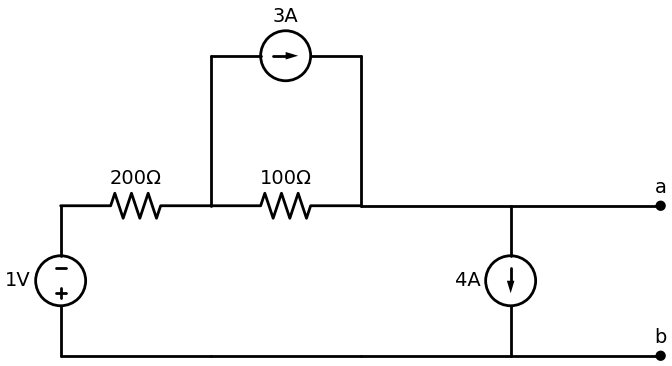

In [3]:
import schemdraw
import schemdraw.elements as elm
import os

# Define circuit component values
V1, V2, I1, I2, R1, R2 = 1, 2, 3, 4, 100, 200 

# Function to generate Circuit 1
d = schemdraw.Drawing()

d += elm.Dot().label('a')
d += elm.Line().left()
d.push()
d += elm.SourceI().down().label(f'{I2}A')
d.pop()
d += elm.Line().left()
d += elm.Line().up()
d += elm.SourceI().left().reverse().label(f'{I1}A')
d += elm.Line().down()
d.push()
d += elm.Resistor().right().label(f'{R1}Ω')
d.pop()
d += elm.Resistor().left().label(f'{R2}Ω')
d += elm.SourceV().down().label(f'{V1}V')
d += elm.Line().right()
d += elm.Line().right()
d += elm.Line().right()
d += elm.Line().right()
d += elm.Dot().label('b')

# Directory setup
folder_name = 'output_circuits'
file_name = 'example_01.png'

os.makedirs(folder_name, exist_ok=True)
file_path = os.path.join(folder_name, file_name)

# Save original schematic
d.save(file_path)

# Apply adversarial techniques
# 1. Apply Warhol Color Overlay
warhol_and_overlay(file_path)

# 2. Generate Adversarial GIF (Polygons -> Text -> Circuit)
gif_filepath = generate_adversarial_gif(file_path)

# Display the schematic in the notebook
d.draw()